In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/7948ada9-eabc-4cb7-a579-b73e938eb716___RS_HL 4185.JPG
/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/f5bd2732-197b-4d8e-bb50-a4966dc416f5___RS_HL 1840.JPG
/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/5a3fc4bb-a78c-4276-8934-f0b037ffb860___RS_HL 5412.JPG
/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/875d6ded-5f01-495c-a945-ad2e17f87f91___RS_HL 1848.JPG
/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/4ae82355-6885-40e7-9807-dabe46ed3441___RS_HL 5410.JPG
/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/f30983c0-6e20-43cc-8672-4622ca34c830___RS_HL 1949.JPG
/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/5df30492-0b54-474d-8883-bba9474ca88f___RS_HL 1801.JPG
/kaggle/input/potato-plant-disease

# **Import**

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

2024-07-01 12:25:16.798572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 12:25:16.798707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 12:25:16.974019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Import & Preprocessing**

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 180
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


# **Data Visualization**

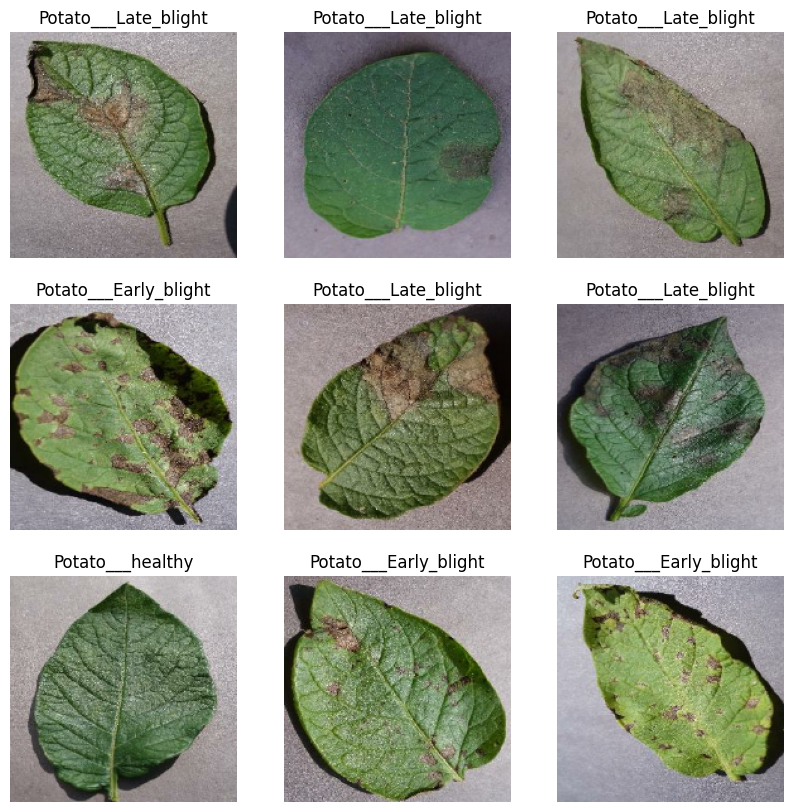

In [5]:
class_names = dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

In [7]:
len(dataset)

68

## **Train,Test, Valid split**

In [8]:
# train data 0.8 , test data 0.1, valid data 0.1
trainsize = 0.8 
len(dataset)*trainsize

54.400000000000006

In [9]:
train_ds = dataset.take(54)

In [10]:
testsize = 0.1
len(dataset)*testsize

6.800000000000001

In [11]:
test_ds = dataset.skip(54)
test_ds = test_ds.skip(6)

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = train_ds.take(6)

In [14]:
def get_dataset_partitions_tf(ds ,train_split = 0.8 , val_split = 0.1 ,test_split =0.1 ,shuffle = True, shuffle_size= 1000):
    assert(train_split + test_split + val_split) == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size , seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds, test_ds
train_ds ,val_ds, test_ds   = get_dataset_partitions_tf(dataset)
len(val_ds)

6

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## **Modeling**

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## **Model Compile**

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## **Model fit**

In [19]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs=10
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 570ms/step - accuracy: 0.6162 - loss: 1.0271 - val_accuracy: 0.8385 - val_loss: 0.4119
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 530ms/step - accuracy: 0.8892 - loss: 0.3083 - val_accuracy: 0.9531 - val_loss: 0.1433
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 524ms/step - accuracy: 0.9537 - loss: 0.1382 - val_accuracy: 0.9375 - val_loss: 0.1458
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 526ms/step - accuracy: 0.9623 - loss: 0.1179 - val_accuracy: 0.9583 - val_loss: 0.1436
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 528ms/step - accuracy: 0.9668 - loss: 0.1189 - val_accuracy: 0.9792 - val_loss: 0.0599
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 530ms/step - accuracy: 0.9799 - loss: 0.0581 - val_accuracy: 0.9740 - val_loss: 0.0747
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 528ms/step - accuracy: 0.9616 - loss: 0.0917 - val_accuracy: 0.9688 - val_loss: 0.0788
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 528ms/step - accuracy: 0.9760 - loss: 0.0637 - val_accu

In [20]:
score = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9904 - loss: 0.0171


## **Evaluation & Prediction**

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

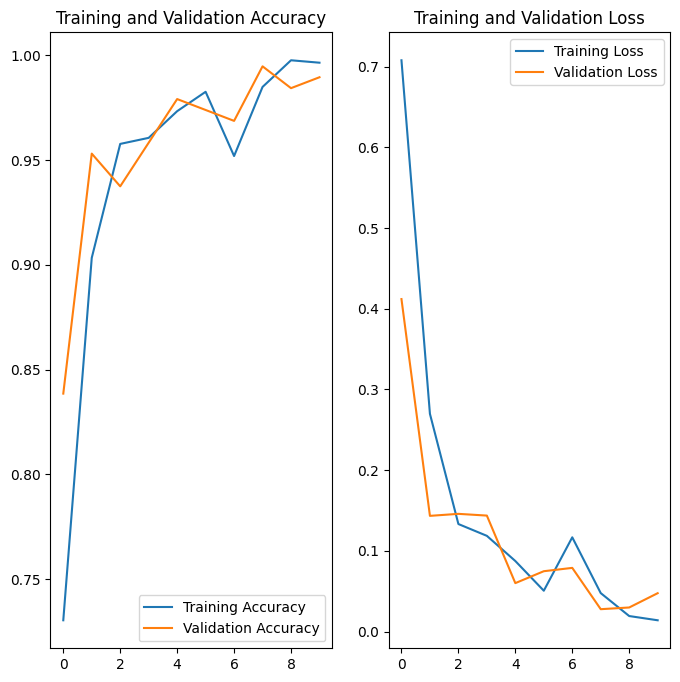

In [23]:
epochs = 10

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
pred = model.predict(val_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
predicted label: Potato___Early_blight


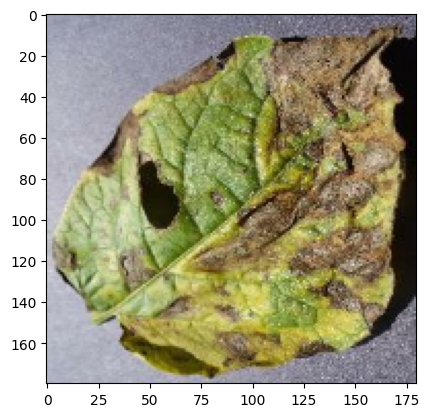

In [25]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.show()

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


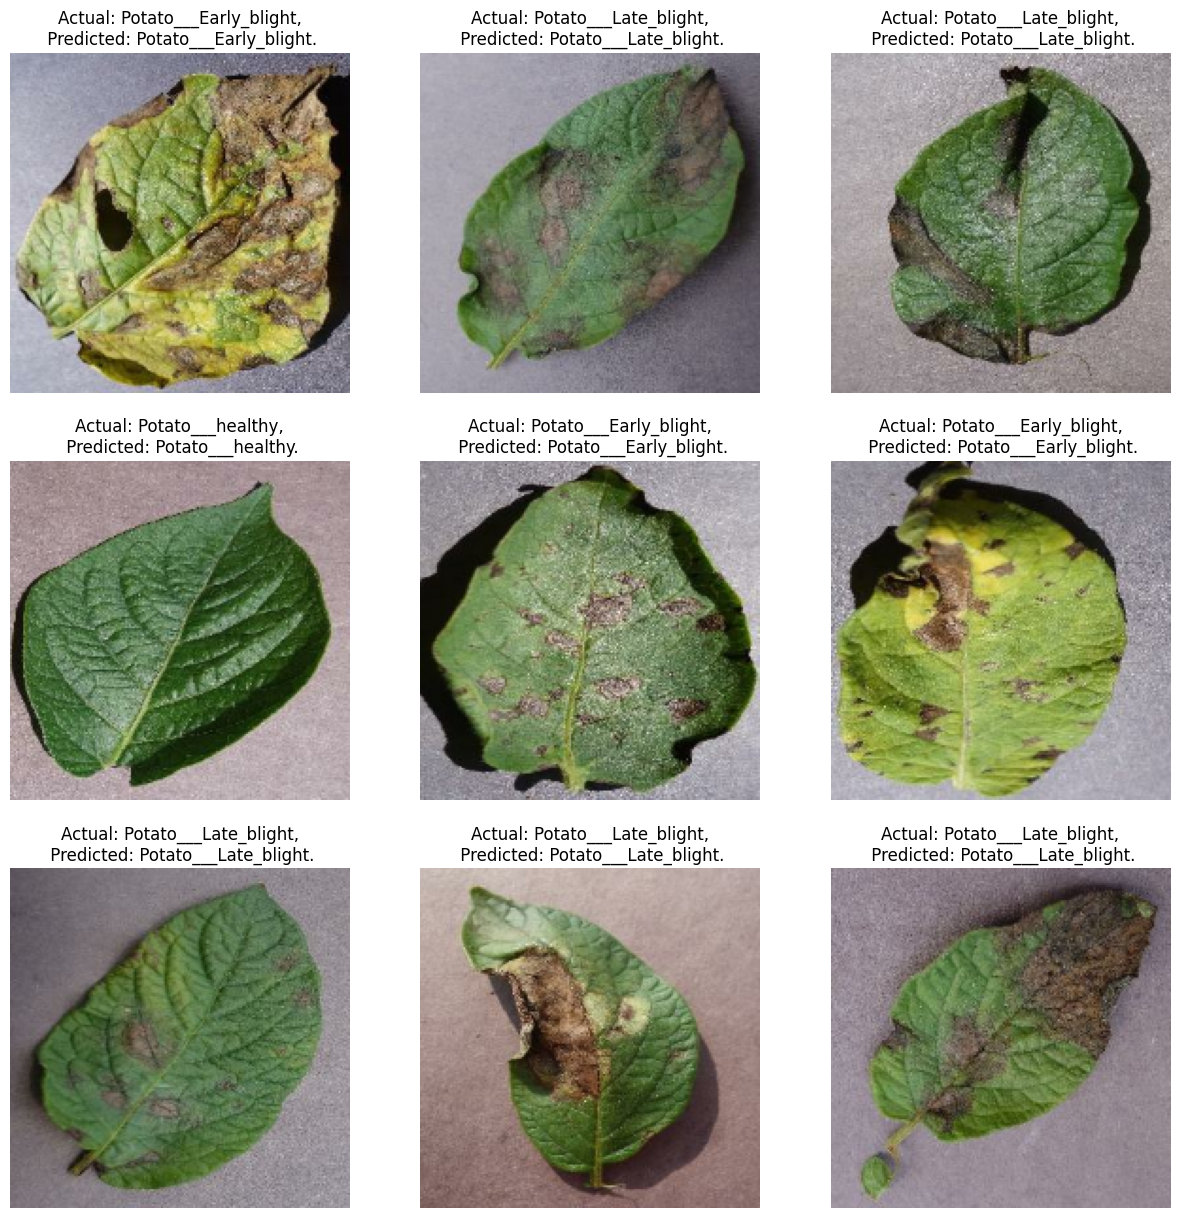

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.")

        plt.axis("off")

**Please leave your advice in the comments. Thank you**